# Librerías y funciones de utilidad

In [1]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import numpy as np
from numpy import linalg as la
from scipy.optimize import minimize

# Integrador 
from scipy.integrate import solve_ivp

# Para graficar
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from seaborn import color_palette

# Para poner dos leyendas en un mismo axis
from matplotlib.legend import Legend

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# Configuración general
# ----------------------------------------------------------------------

np.random.seed(2023)

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False

# ----------------------------------------------------------------------
# Constantes que se van a utilizar a lo largo de todo el notebook
# ----------------------------------------------------------------------

# Matriz rotación 90º
E = np.array([[0, -1],[1, 0]])

# Reescalado afín
M_scale = lambda s, n=2: np.eye(n)*s

# Rotación
M_rot = lambda psi: np.array([[np.cos(psi), -np.sin(psi)], \
                              [np.sin(psi),  np.cos(psi)]])

# Producto matricial de Q sobre cada fila de X
Q_prod_xi = lambda Q,X: (Q @ X.T).T

# Ángulo entre dos vectores (computación matricial)
def angle_of_vectors(A,B):
    cosTh = np.sum(A*B, axis=1)
    sinTh = np.cross(A,B, axis=1)
    theta = np.arctan2(sinTh,cosTh)
    return theta

In [2]:
# ----------------------------------------------------------------------
# Algunas funciones de utilidad
# ----------------------------------------------------------------------

from matplotlib.path import Path
import matplotlib.patches as patches

"""
Unicycle patch (Héctor García de Marina)
  * XY: position [X, Y] of the patch 
  * yaw: heading of the unicycle
"""
def unicycle_patch(XY, yaw, color, size=1, lw=0.5):
    Rot = np.array([[np.cos(yaw), np.sin(yaw)],[-np.sin(yaw), np.cos(yaw)]])

    apex = 45*np.pi/180 # 30 degrees apex angle
    b = np.sqrt(1) / np.sin(apex)
    a = b*np.sin(apex/2)
    h = b*np.cos(apex/2)

    z1 = size*np.array([a/2, -h*0.3])
    z2 = size*np.array([-a/2, -h*0.3])
    z3 = size*np.array([0, h*0.6])

    z1 = Rot.dot(z1)
    z2 = Rot.dot(z2)
    z3 = Rot.dot(z3)

    verts = [(XY[0]+z1[1], XY[1]+z1[0]), \
             (XY[0]+z2[1], XY[1]+z2[0]), \
             (XY[0]+z3[1], XY[1]+z3[0]), \
             (0, 0)]

    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)

    return patches.PathPatch(path, fc=color, lw=lw)

"""
Compute a 1D range zoomed around center.
(moded from https://gist.github.com/dukelec/e8d4171ef4d12f9998295cfcbe3027ce)
  * begin: The begin bound of the range.
  * end: The end bound of the range.
  * center: The center of the zoom (i.e., invariant point)
  * scale_factor: The scale factor to apply.
:return: The zoomed range (min, max)
"""
def _zoom_range(begin, end, center, scale_factor):
  if begin < end:
      min_, max_ = begin, end
  else:
      min_, max_ = end, begin

  old_min, old_max = min_, max_

  offset = (center - old_min) / (old_max - old_min)
  range_ = (old_max - old_min) / scale_factor
  new_min = center - offset * range_
  new_max = center + (1. - offset) * range_

  if begin < end:
      return new_min, new_max
  else:
      return new_max, new_min

"""
Mapa de color con un alpha determinado
https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
----------------------------------------------------------------------

A la hora de usar pcolormesh no podemos aplicar directamente un alpha
da muchos problemas. Lo ideal es generar y utilizar un mapa de colores
ya diluido sobre un fondo blanco.
"""
def alpha_cmap(cmap, alpha):
  # Get the colormap colors
  my_cmap = cmap(np.arange(cmap.N))
  # Define the alphas in the range from 0 to 1
  alphas = np.linspace(alpha, alpha, cmap.N)
  # Define the background as white
  BG = np.asarray([1., 1., 1.,])
  # Mix the colors with the background
  for i in range(cmap.N):
      my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
  # Create new colormap which mimics the alpha values
  my_cmap = ListedColormap(my_cmap)
  return my_cmap

my_cmap = alpha_cmap(plt.cm.jet, 0.3)

"""
Comprueba que las dimensiones son correctas y adapta la entrada a 2D.
"""
def two_dim(X):
  if type(X) == list:
    return np.array([[X]])
  elif len(X.shape) < 2:
    return np.array([X])
  else:
    return X

# Campo escalar $\sigma$

In [3]:
# ----------------------------------------------------------------------
# Clase general para el campo escalar
# ----------------------------------------------------------------------
"""
Clase para campo escalar gaussiano.
  * max_intensity: máxima intensidad de la gaussiana
  * list mu: punto central de la gaussiana
  * dev: desviación estándar
  * R: matriz de rotación del campo
"""
class sigma:
  def __init__(self, sigma_func, mu=None):
    self.sigma_func = sigma_func
    self.rot = None #Variable que nos permite rotar el campo desde fuera
    if mu is None:
      x0 = self.sigma_func.x0 # Pide ayuda para buscar mínimo
      self.mu = minimize(lambda x: la.norm(self.grad(np.array([x]))), x0).x
    else:
      self.mu = minimize(lambda x: la.norm(self.grad(np.array([x]))), mu).x

  """
  Evaluación del campo escalar para un vector de valores.
  """
  def value(self, X):
    if self.rot is not None:
      X = Q_prod_xi(self.rot, X-self.mu) + self.mu
    return self.sigma_func.eval(X)

  """
  Vector gradiente del campo escalar para un vector de valores
  """
  def grad(self, X):
    if self.rot is not None:
      X = Q_prod_xi(self.rot, X-self.mu) + self.mu
      grad = self.sigma_func.grad(X)
      return Q_prod_xi(self.rot.T, grad)
    else:
      return self.sigma_func.grad(X)

  """
  Función para dibujar el campo escalar.
  """
  def draw(self, fig=None, ax=None, xlim=30, ylim=30, cmap=my_cmap, n=256, contour_levels=0):
    if fig == None:
      fig = plt.figure(figsize=(16, 9), dpi=100)
      ax = fig.subplots()
    elif ax == None:
      ax = fig.subplots()

    # Calculamos
    x = np.linspace(self.mu[0] - xlim, self.mu[0] + xlim, n) 
    y = np.linspace(self.mu[1] - ylim, self.mu[1] + ylim, n) 
    X, Y = np.meshgrid(x, y) 

    P = np.array([list(X.flatten()), list(Y.flatten())]).T
    Z = self.value(P).reshape(n,n)
    
    # Dibujamos
    ax.plot(self.mu[0], self.mu[1], "+k")
    color_map = ax.pcolormesh(X, Y, Z, cmap=cmap)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)

    cbar = fig.colorbar(color_map, cax=cax)
    #cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='$\sigma$ [u]', labelpad=10)

    if contour_levels != 0:
      contr_map = ax.contour(X, Y, Z, contour_levels, colors="k", linewidths=0.3, linestyles="dashdot")
      return color_map, contr_map
    else:
      return color_map,
  
  def draw_imshow(self, fig=None, ax=None, xlim=30, ylim=30, cmap=my_cmap, n=256, make_im=True):
    # Calculamos
    x = np.linspace(self.mu[0] - xlim, self.mu[0] + xlim, n) 
    y = np.linspace(self.mu[1] - ylim, self.mu[1] + ylim, n) 
    X, Y = np.meshgrid(x, y) 

    P = np.array([list(X.flatten()), list(Y.flatten())]).T
    Z = self.value(P).reshape(n,n)

    if make_im:
      extent = np.min(x), np.max(x), np.min(y), np.max(y)

      if fig == None:
        fig = plt.figure(figsize=(16, 9), dpi=100)
        ax = fig.subplots()
      elif ax == None:
        ax = fig.subplots()

      # Dibujamos
      ax.plot(self.mu[0], self.mu[1], "+k")
      im = ax.imshow(Z, cmap=cmap, interpolation="nearest", extent=extent)

      divider = make_axes_locatable(ax)
      cax = divider.append_axes('right', size='2%', pad=0.05)

      cbar = fig.colorbar(im, cax=cax)
      cbar.set_label(label='$\sigma$ [u]', labelpad=10)
      return im

    else:
      return Z

  """
  Función para dibujar el gradiente en un punto.
    * x: punto en el que se desea dibujar el gradiente
    * ax: axis sobre el que plottear
    * width: tamaño de la flecha
    * scale: modela la longitus de la flecha (más pequeña cuanto mayor sea scale)
    * zorder: orden de superposición en el gráfico
  """
  def draw_grad(self, x, ax, width=0.002, scale=30, zorder=2):
    if type(x) == list:
      grad_x = self.grad(np.array(x))[0]
    else:
      return None
    grad_x_unit = grad_x/la.norm(grad_x)
    quiver = ax.quiver(x[0], x[1], grad_x_unit[0], grad_x_unit[1], 
                        width=width, scale=scale, zorder=zorder)
    return quiver

# ----------------------------------------------------------------------
# Distintos campos escalares que usaremos en las simulaciones
# (todas estas clases necesitan una función eval)
# ----------------------------------------------------------------------

# Función exponencial con forma cuadrática: exp(r) = e^((r - mu)^t @ Q @ (r - mu))
exp = lambda X,Q,mu: np.exp(np.sum((X - mu) * Q_prod_xi(Q,X - mu), axis=1))

"""
Función gaussiana
  * a: centro de la gaussiana
  * dev: modela la anchura de la gaussiana
"""
class sigma_gauss:
  def __init__(self, mu=[0,0], n=2, max_intensity=100, dev=10, S=None, R=None):
    self.n = n
    self.max_intensity = max_intensity
    self.dev = dev

    # Variables necesarias para la clase sigma
    self.x0  = mu
    # ---

    if S is None:
      S = -np.eye(n)
    if R is None:
      R = np.eye(n)
    self.Q = R.T@S@R/(2*self.dev**2)

  def eval(self, X):
    X = two_dim(X)
    sigma = self.max_intensity * exp(X,self.Q,self.x0) / np.sqrt(2*np.pi*self.dev**2)
    return sigma
  
  def grad(self, X):
    X = two_dim(X)
    return Q_prod_xi(self.Q,X-self.x0) * self.eval(X)

"""
Función no convexa: dos gaussianas más factor * norma (paper Source Seeking)
  * k: factor de la norma
  * dev: modela la escala de la distribución manteniendo sus propiedades
"""
# Parámetros predeterminados
S1 = 0.9*np.array([[1/np.sqrt(30),0], [0,1]])
S2 = 0.9*np.array([[1,0], [0,1/np.sqrt(15)]])
A = (1/np.sqrt(2))*np.array([[1,-1], [1,1]])
a = [1, 0]
b = [0,-2]

class sigma_nonconvex:
  def __init__(self, k, mu=[0,0], dev=1, a=a, b=b, Qa=-S1, Qb=-A.T@S2@A):
    self.k = k
    self.dev = dev

    # Variables necesarias para la clase sigma
    self.x0 = mu
    self.rot = np.eye(2)
    # ---

    if type(a) == list:
      a = np.array(a)
    if type(b) == list:
      b = np.array(b)
    self.a = a
    self.b = b
    self.Qa = Qa
    self.Qb = Qb

  def eval(self, X):
    X = two_dim(X)
    X = (X - self.x0)/self.dev
    sigma = - 2 - exp(X,self.Qa,self.a) - exp(X,self.Qb,self.b) + self.k*la.norm(X, axis=1)
    return -sigma

  def grad(self, X):
    X = two_dim(X)
    X = (X - self.x0)/self.dev
    alfa = 0.0001 # Para evitar indeterminación de 0/0 (el truquito de Fran xD)
    sigma_grad = - Q_prod_xi(self.Qa,X-self.a) * exp(X,self.Qa,self.a)[:,None] \
                 - Q_prod_xi(self.Qb,X-self.b) * exp(X,self.Qb,self.b)[:,None] \
                 + self.k * X / (la.norm(X, axis=1)[:,None] + alfa) 
    return -sigma_grad

"""
Analizando el caso anterior, proponemos una función que nos permite jugar mucho más con la generación de campos escalares
  * k: factor de la norma
  * dev: modela la escala de la distribución manteniendo sus propiedades
"""
# Parámetros predeterminados


class sigma_3gauss:
  def __init__(self, k, mu=[0,0], dev=1, a=a, b=b, Qa=-S1, Qb=-A.T@S2@A):
    self.mu = mu
    self.k = k
    self.dev = dev
    if type(a) == list:
      a = np.array(a)
    if type(b) == list:
      b = np.array(b)
    self.a = a
    self.b = b
    self.Qa = Qa
    self.Qb = Qb
    self.x0 = self.mu

  def eval(self, X):
    X = two_dim(X)
    X = (X - self.mu)/self.dev
    sigma = - 2 - exp(X,self.Qa,self.a) - exp(X,self.Qb,self.b) + self.k*la.norm(X, axis=1)
    return -sigma

  def grad(self, X):
    X = two_dim(X)
    X = (X - self.mu)/self.dev
    alfa = 0.0001 # Para evitar indeterminación de 0/0 (el truquito de Fran xD)
    sigma_grad = - Q_prod_xi(self.Qa,X-self.a) * exp(X,self.Qa,self.a)[:,None] \
                 - Q_prod_xi(self.Qb,X-self.b) * exp(X,self.Qb,self.b)[:,None] \
                 + self.k * X / (la.norm(X, axis=1)[:,None] + alfa) 
    return -sigma_grad

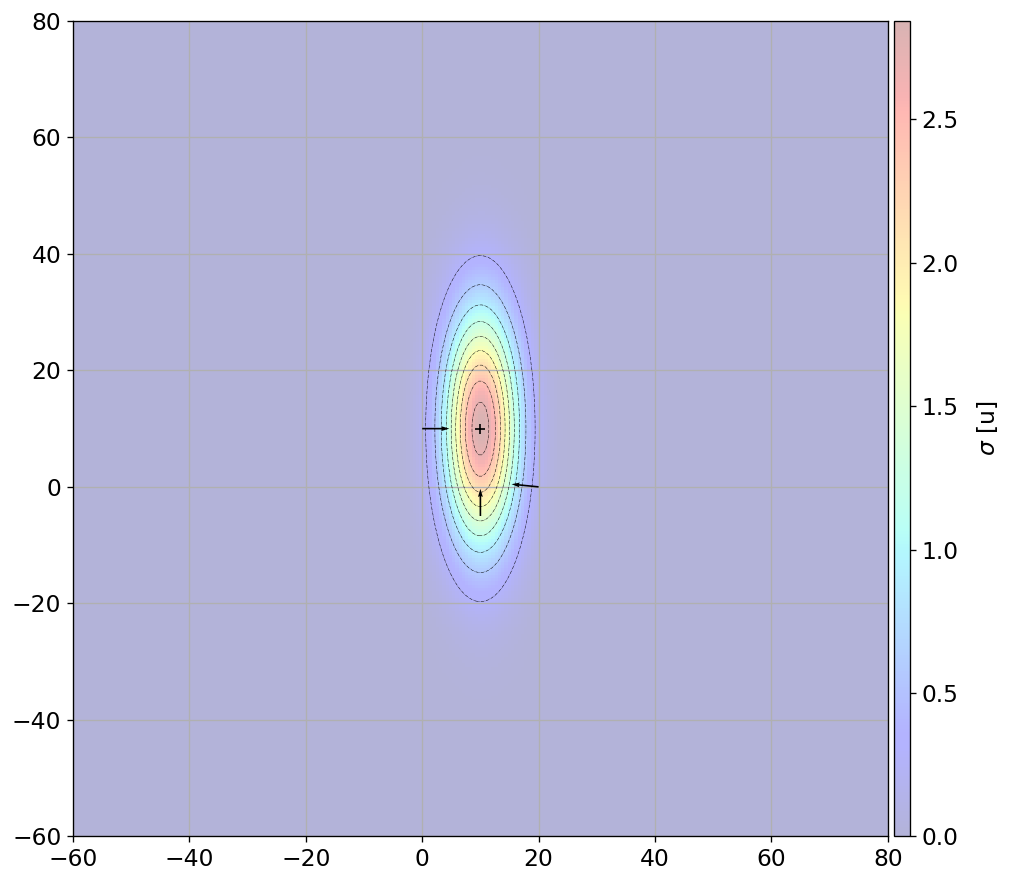

In [4]:
# ----------------------------------------------------------------------
# Testeamos gaussiana
# ----------------------------------------------------------------------

mu = [10,10]
max_int = 100
dev = 14

psi = 45 * np.pi / 180
ab_ = 10

# Generamos el campo escalar
S = -np.array([[1,0],[0,ab_]])
R =  M_rot(psi)
R2 = M_rot(psi)

sigma_func = sigma_gauss(mu=mu, max_intensity=max_int, dev=dev, S=S, R=R)
sigma_test = sigma(sigma_func)
sigma_test.rot = R2

# Generamos el gráfico
font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

fig = plt.figure(figsize=(9, 9), dpi=120)
ax = fig.subplots()

# Dibujamos el campo escalar
sigma_test.draw(fig=fig, ax=ax, xlim=70, ylim=70, n=250, contour_levels=10)

# Dibujamos varios gradientes
sigma_test.draw_grad([0,10], ax, width=0.002, scale=30)
sigma_test.draw_grad([20,0], ax, width=0.002, scale=30)
sigma_test.draw_grad([10,-5], ax, width=0.002, scale=30)

ax.grid(True)
plt.show()

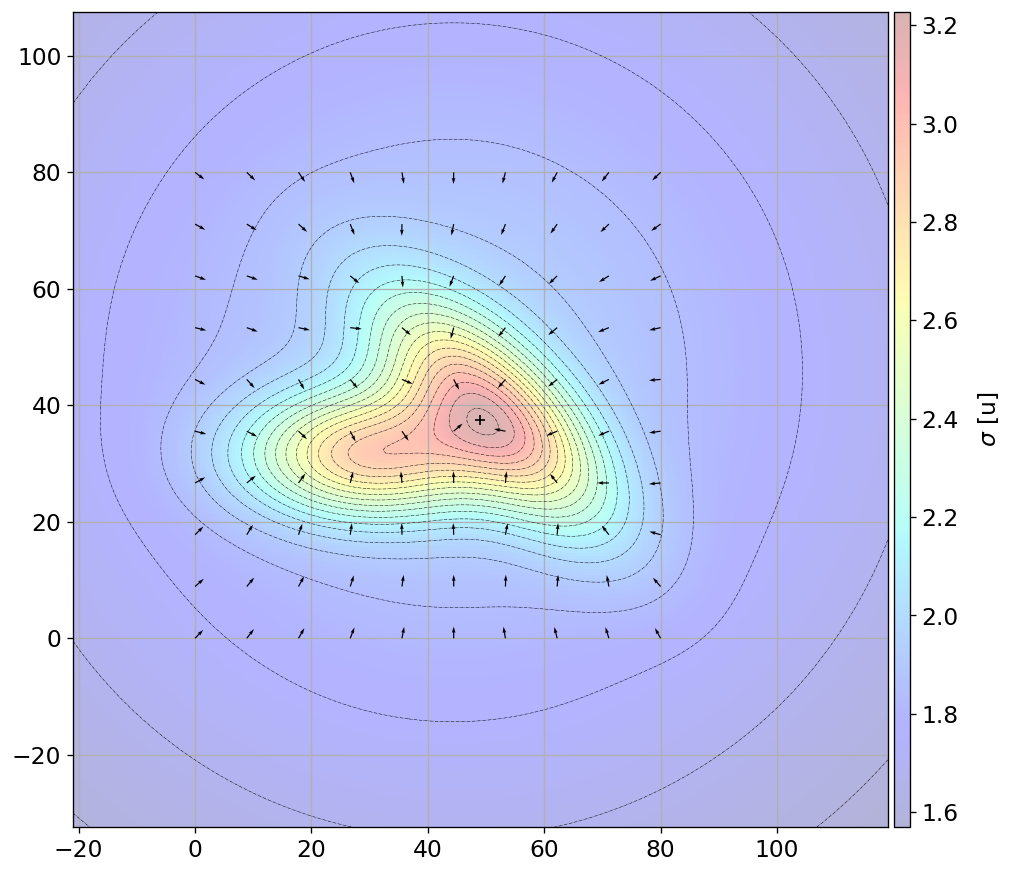

In [5]:
# ----------------------------------------------------------------------
# Testeamos no-convexa
# ----------------------------------------------------------------------

psi = 45 * np.pi / 180

# Generamos el campo escalar
R2 = M_rot(psi)

sigma_func = sigma_nonconvex(k=0.04, dev=10, mu=[40,40])
sigma_test = sigma(sigma_func)
sigma_test.rot = R2

# Generamos el gráfico
font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

fig = plt.figure(figsize=(9, 9), dpi=120)
ax = fig.subplots()

# Dibujamos el campo escalar
sigma_test.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

x = np.linspace(0,80,10)
y = np.linspace(0,80,10)
for xi in x:
  for yi in y:
    sigma_test.draw_grad([xi,yi], ax, width=0.0015, scale=70)

ax.grid(True)
plt.show()

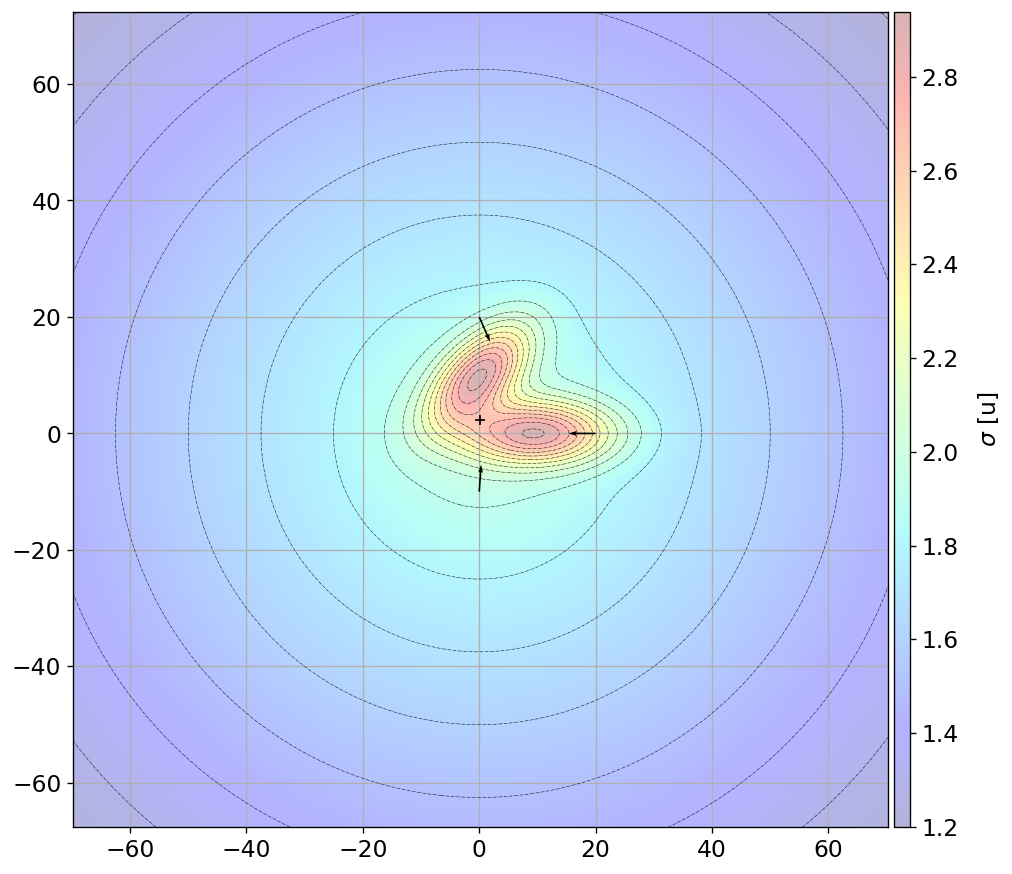

In [6]:
# ----------------------------------------------------------------------
# Testeamos un campo escalar que no nos sirve
# ----------------------------------------------------------------------

sigma_func = sigma_nonconvex(k=0.04, dev=5, a=[2,0], b=[0,2])
#sigma_test = sigma(sigma_func)
sigma_test = sigma(sigma_func, [0,0])
#sigma_test = sigma(sigma_func, [10,0])

# Generamos el gráfico
font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

fig = plt.figure(figsize=(9, 9), dpi=120)
ax = fig.subplots()

# Dibujamos el campo escalar
sigma_test.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

# Dibujamos varios gradientes
sigma_test.draw_grad([0, 20], ax, width=0.002, scale=30)
sigma_test.draw_grad([20, 0], ax, width=0.002, scale=30)
sigma_test.draw_grad([0,-10], ax, width=0.002, scale=30)

ax.grid(True)
plt.show()

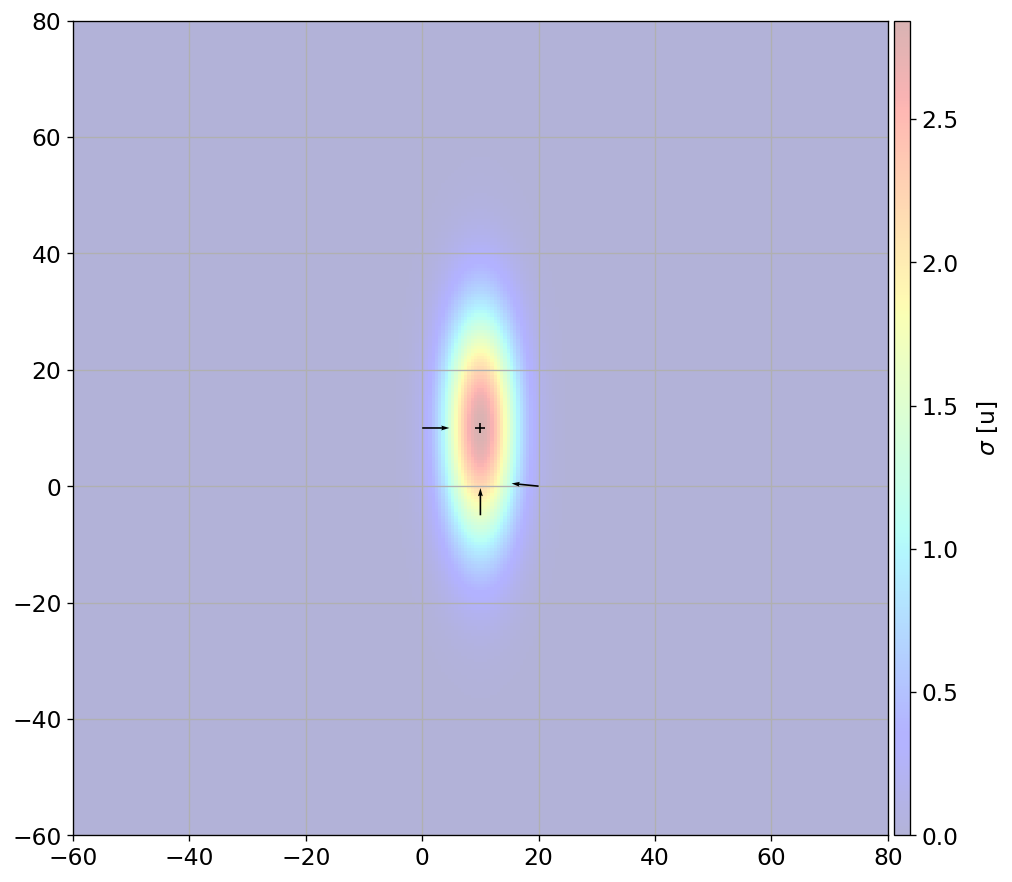

In [7]:
# ----------------------------------------------------------------------
# Testeamos gaussiana
# ----------------------------------------------------------------------

mu = [10,10]
max_int = 100
dev = 14

psi = 45 * np.pi / 180
ab_ = 10

# Generamos el campo escalar
S = -np.array([[1,0],[0,ab_]])
R =  M_rot(psi)
R2 = M_rot(psi)

sigma_func = sigma_gauss(mu=mu, max_intensity=max_int, dev=dev, S=S, R=R)
sigma_test = sigma(sigma_func)
sigma_test.rot = R2

# Generamos el gráfico
font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

fig = plt.figure(figsize=(9, 9), dpi=120)
ax = fig.subplots()

# Dibujamos el campo escalar
sigma_test.draw_imshow(fig=fig, ax=ax, xlim=70, ylim=70, n=250)

# Dibujamos varios gradientes
sigma_test.draw_grad([0,10], ax, width=0.002, scale=30)
sigma_test.draw_grad([20,0], ax, width=0.002, scale=30)
sigma_test.draw_grad([10,-5], ax, width=0.002, scale=30)

ax.grid(True)
plt.show()

In [8]:
l = [1,2,3,4,5]
l[1:]

[2, 3, 4, 5]

# Simulaciones

In [9]:
"""
Clase común a todas las simulaciones
  * x0: [t0, p0, v0, ...]
  * n: dimensión del espacio real
  ---------------------------------
  * P: matriz de posiciones (N x n)
  * V: matriz de posiciones (N x n)
"""
class sim_frame:
  def __init__(self, n_agents, x0, dt):
    self.t0 = x0[0]              # Tiempo inicial de la simulación (s)
    self.tf = x0[0]              # Tiempo actual de la simulación (s)
    self.dt = dt                 # Pasos temporales en la simulación (s)

    self.N  = n_agents           # Número de agentes simulados
    
    # Lista con vectores de estado
    self.states = x0[1:]   

  """
  Aproximación para la dirección de ascenso.
    * sigma: vector (N x 1)
    * X: matriz de posiciones relativas al centroide (N x n)
  """
  def L_sigma(self, X, sigma):
    x_norms = np.zeros((self.N))
    for i in range(self.N):
      x_norms[i] = X[i,:] @ X[i,:].T
    D = np.max(x_norms)
    l_sigma_hat = sigma[:,None].T @ X / (self.N * D**2)
    return l_sigma_hat.flatten()

  """
  Euler integrator.
    * dX: lista de matrices con las mismas dimensiones que self.states.
  """
  def int_euler(self, dX): #TODO: Poder elegir entre RK4 y euler 
    self.tf = self.tf + self.dt
    if len(self.states) == len(dX):
      for i in range(len(self.states)):
        self.states[i] = self.states[i] + dX[i] * self.dt
    else:
      print("El vctor dX no tiene el mismo tamaño que el vector de estados.")

# ----------------------------------------------------------------------
# Funciones de utilidad para todas las simulaciones
# ----------------------------------------------------------------------

"""
Función para generar una distribución circular uniforme.
  * N: número de puntos
  * n: dimensión del espacio real
  * rc0: posición en el espacio real del punto central
  * r: radio del círculo
  * h: mínimo del radio de aparación con respecto al centro
  * border_noise: ruido generado en la frontera para no tener un círculo perfecto
"""
#TODO: Ajustar la distribución para que sea uniforme en un espacio curvo
def circular_distrib(N, n, rc0, r, h=0, border_noise=0.1): 
  rand_ang = 2*np.pi*np.random.rand(N)
  rand_dirs = np.array([np.cos(rand_ang), np.sin(rand_ang)]).T
  rand_rads = (r - h)*np.random.rand(N) + h + border_noise*np.random.rand(N)
  X0 = rand_rads[:,None] * rand_dirs/la.norm(rand_dirs, axis=1)[:,None]
  return rc0 + X0

"""
Función para generar distribuciones rectangulares uniformes.
  * N: número de puntos
  * n: dimensión del espacio real
  * rc0: posición en el espacio real del punto central
"""
def XY_distrib(N, n, rc0, lims, border_noise=0.1, scale=1):
  X0 = (np.random.rand(N,n) - 0.5)*2
  for i in range(n):
    X0[:,i] = X0[:,i] * lims[i] 
  X0 = X0 @ M_scale(scale, n)
  return rc0 + X0

## Simulación tipo 1: *Un único cluster que modifica su forma y número de agentes*

Caracterísitcas de la misión:
 
* Contamos con un único enjambre. 
* Podremos generar N agentes distribuidos de distintas formas entorno a un centroide. 
* El enjambre podrá modificar su forma a lo largo de la simulación.
* Se podrán añadir y eliminar agentes del enjambre durange la simulación. #TODO

In [ ]:
# ----------------------------------------------------------------------
# Simulation I class 
# ----------------------------------------------------------------------

"""
Simulation I
  * x0: Vector de parámetros iniciales
    - t0: tiempo inicial de la simulación
    - p0: matriz con la posición inicial de cada agente.
    - v0: velocidad constante para todos los agentes.
    - active: agentes activos al comenzar la simulación
"""
class arquimides_sim1:
  def __init__(self, sigma_field, n_agents, x0, dt = 0.01, mod_shape = False):
    t0 = x0[0]
    p0 = x0[1]
    v0 = x0[2]
    
    self.N = n_agents
    self.dt = dt

    # Generamos el simulation frame
    self.sim_frame = sim_frame(self.N, [t0,p0], self.dt)

    # Vector de activación de los agentes
    if len(x0)>3:
      self.active = x0[3]                               
    else:
      self.active = np.ones(n_agents, dtype=bool)

    # Estados de esta simulación
    self.vf = v0                                       # Velocidad común constante
    self.sigma_field = sigma_field                     # Clase campo escalar 
    self.sigma = self.sigma_field.value(p0)            # Sigmas medidos (N x 1)

    self.rc = np.mean(p0[self.active,:], axis=0)   
    self.rc_e = la.norm(self.rc - self.sigma_field.mu) # Distancia hasta la fuente
    self.rc_sigma = self.sigma_field.value(self.rc)[0] # Sigma en el centroide
    self.X = p0 - self.rc                              # Geometría del enjambre
    self.d = la.norm(self.X, axis=1)                   # Distancia al centroide

    self.l_sigma_hat = np.zeros(2)
    self.rc_grad = self.sigma_field.grad(self.rc)[0]

    # Variables útiles para esta simulación
    self.mod_shape = mod_shape                         # Switch control geometría
    self.Xd = self.X                                   # Geometría deseada

    # Constantes recicladas de sim_frame para facilitar acceso desde fuera


  """
  Extraer los resultados de la simulación.
  """
  def get_tf(self):
    return self.sim_frame.tf

  def get_pf(self):
    return self.sim_frame.states[0]

  """
  Dinámica libre que sigue dirección de ascenso (celeridad constante)
    * X: matriz de distancias relativas al centroide (N x n) xi = [px, py, pz]
    * sigma: vector con las medidas de sigma_field de cada agente (N x 1)
  """
  def free_kinematics(self, X):
    l_sigma_hat = self.sim_frame.L_sigma(X, self.sigma)
    l_sigma_hat_norm = la.norm(l_sigma_hat)
    if l_sigma_hat_norm != 0:
      self.l_sigma_hat = l_sigma_hat / l_sigma_hat_norm
    else:
      self.l_sigma_hat = np.zeros(2)
    p_dot = self.vf * self.l_sigma_hat * np.ones(X.shape)
    return p_dot

  def shape_control(self):
    return (self.Xd - self.X)/10

  """
  Integración paso a paso.
  """
  def int_step(self):
    self.rc = np.mean(self.get_pf()[self.active,:], axis=0) 
    self.rc_e = la.norm(self.rc - self.sigma_field.mu)
    self.rc_sigma = self.sigma_field.value(self.rc)[0]
    self.rc_grad = self.sigma_field.grad(self.rc)[0]
    self.rc_grad = self.rc_grad/la.norm(self.rc_grad)

    self.X = self.get_pf() - self.rc
    self.d = la.norm(self.X, axis=1)
    self.sigma = self.sigma_field.value(self.get_pf())

    # Calculamos p_dot y se lo pasamos al sim_frame
    X_active = np.diag(self.active) @ self.X
    p_dot = self.free_kinematics(X_active)
    if self.mod_shape:
      p_dot = p_dot + self.shape_control()
    p_dot_active = np.diag(self.active) @ p_dot
    self.sim_frame.int_euler([p_dot_active])

### Equipo de 5 agentes buscando la fuente

In [ ]:
# ----------------------------------------------------------------------
# Generamos el campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [20,14]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 60


# Estado inicial de los agentes y número de agentes
p0 = np.array([[0.0, -1.4], [-1, 0.5], [1.5, -1.7], [1.9, -2.1], [2.5, 1.1]])
p0 = (p0*1.3 - [10, 20]) 
v0 = 1

n_agents = p0.shape[0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim1(sigma_field, n_agents, [t0, p0, v0], dt)

# Realizamos toda la simulación mumerica
xdata, ydata = [], []
rc_xdata, rc_ydata = [], []
edata, ddata = [], []
sigma_data = []
field_rot = None

while (sim.get_tf() <= t_sim_final - dt/10):
  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)

  sim.int_step()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)

IndexError: ignored

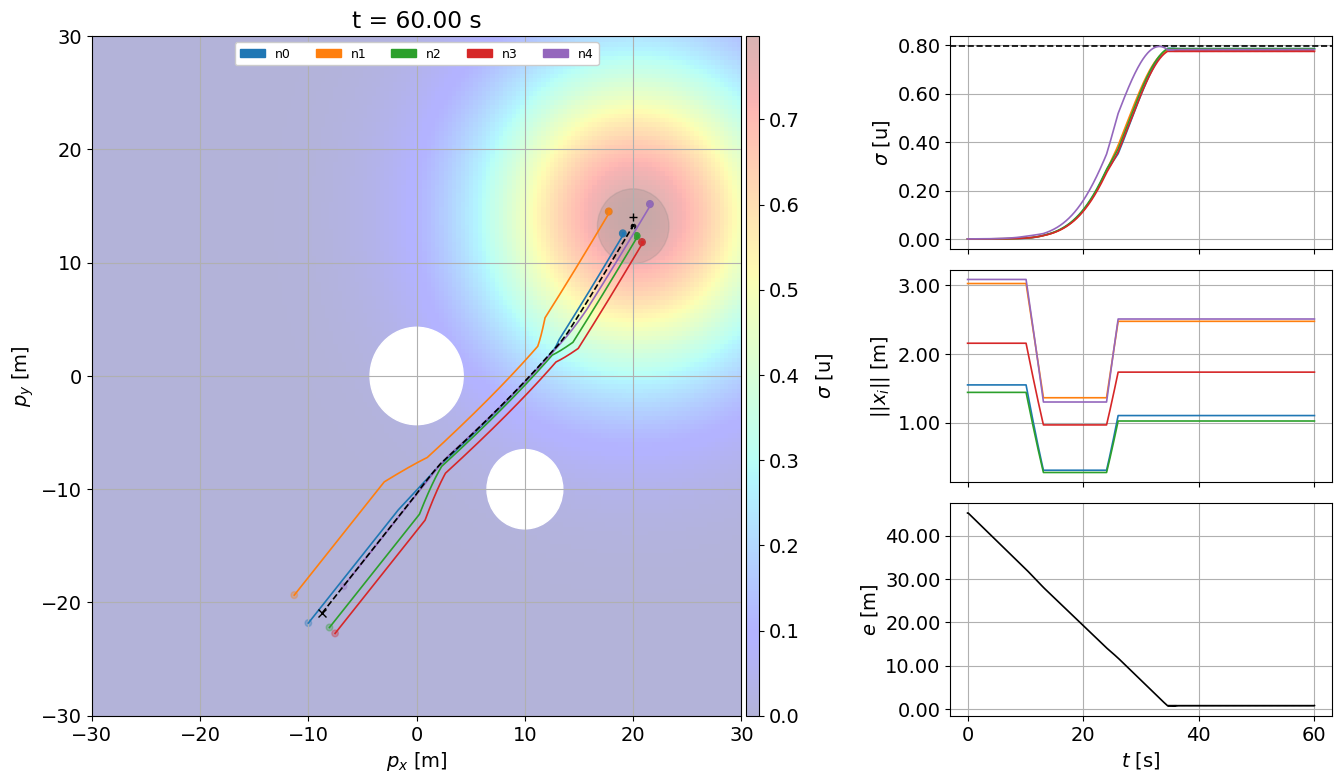

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(16, 9), dpi=100)
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$e$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)

# -------------
# Main ax init
# -------------
sigma_field.draw(fig, main_ax, xlim=50, ylim=50)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))
main_ax.grid(True)

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n]

  cicle_rad = 0.3
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), cicle_rad, color=color)
  icon_init.set_alpha(0.3)
  icon = plt.Circle((xdata[li,n], ydata[li,n]), cicle_rad, color=color)
  icon.set_label("n"+str(n))
  
  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

delta = 0.8
cluster_rad = np.max(ddata[li,:]) + delta
icon_cluster = plt.Circle((rc_xdata[li], rc_ydata[li]), cluster_rad, 
                          alpha=0.2, color="grey")

main_ax.plot(rc_xdata[0], rc_ydata[0], "x", c="k")
main_ax.plot(rc_xdata[:],rc_ydata[:], c="k", ls="--", lw=1.2)
main_ax.scatter(rc_xdata[li], rc_ydata[li], c="k", s=10)
main_ax.add_patch(icon_cluster)

main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})

# Objetos fijos
main_ax.add_patch(plt.Circle((0, 0), 4.3, color="white"))
main_ax.add_patch(plt.Circle((10, -10), 3.5, color="white"))

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt))

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="black", ls="--", lw=1.2)

for n in range(sim.N):
  sigma_data_ax.plot(time_vec, sigma_data[:,n], c=color_palette()[n], lw=1.2)
  ddata_ax.plot(time_vec, ddata[:,n], c=color_palette()[n], lw=1.2)
edata_ax.plot(time_vec, edata[:], c="k", lw=1.2)

plt.show()

In [ ]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

test = True

if test:
  dpi = 100
else:
  dpi = 300

figsize = np.array([16, 9])
std_font = 14
font_params = {'size' : std_font}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$e$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)

# -------------
# Main ax init
# -------------
sigma_field.draw(fig, main_ax, xlim=50, ylim=50)
main_ax.grid(True)

# Agentes
lines_agents = []
icons_agents = []
c_palet = color_palette()
for n in range(sim.N):
  cicle_rad = 0.5
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), cicle_rad, color=c_palet[n])
  icon_init.set_alpha(0.3)
  icon = plt.Circle((xdata[0,n], ydata[0,n]), cicle_rad, color=c_palet[n])
  icon.set_label("n"+str(n))
  

  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[0,n], ydata[0,n], c=c_palet[n], ls="-", lw=1.2)
  
  lines_agents.append(line)
  icons_agents.append(icon)

# Centroides y clusters
lines_centroids = []
icons_centroids = []
icons_clusters  = []

delta = 0.8
cluster_rad = np.max(ddata[0,:]) + delta

line, = main_ax.plot(rc_xdata[0], rc_ydata[0], c="k", ls="--", lw=1.2)
icon_centroid_init = plt.Circle((rc_xdata[0], rc_ydata[0]), 0.1, alpha=0.3, color="k")
icon_centroid = plt.Circle((rc_xdata[0], rc_ydata[0]), 0.1, color="k")
icon_cluster = plt.Circle((rc_xdata[0], rc_ydata[0]), cluster_rad, alpha=0.2, color="grey")

main_ax.add_patch(icon_centroid_init)
main_ax.add_patch(icon_centroid)
main_ax.add_patch(icon_cluster)

lines_centroids.append(line)
icons_centroids.append(icon_centroid)
icons_clusters.append(icon_cluster)

# Objetos fijos
main_ax.add_patch(plt.Circle((0, 0), 4.3, color="white"))
main_ax.add_patch(plt.Circle((10, -10), 3.5, color="white"))

# Leyenda y título
main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt))
data_lines_plt = []
for n in range(sim.N):
  kw = dict(c=c_palet[n], lw=1.2)
  sigma_data_ax.plot(time_vec, sigma_data[:,n], **kw)
  ddata_ax.plot(time_vec, ddata[:,n], **kw)
  edata_ax.plot(time_vec, edata[:], **kw)

sigma_line = sigma_data_ax.axvline(0, c="black", ls="--", lw=1.2)
dline = ddata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_agents[n].remove()
    icons_agents[n] = plt.Circle((xdata[i,n], ydata[i,n]), cicle_rad, color=c_palet[n])
    icons_agents[n].set_zorder(3)

    lines_agents[n].set_data(xdata[0:i,n], ydata[0:i,n])
    main_ax.add_patch(icons_agents[n])
  
  # En esta simulación no tiene sentido el bucle, 
  # pero será interesante cuando tengamos varios clusters
  for k in range(len(lines_centroids)):
    icons_centroids[k].remove()
    icons_centroids[k] = plt.Circle((rc_xdata[i], rc_ydata[i]), 0.1, color="k")
    icons_centroids[k].set_zorder(3)

    cluster_rad = np.max(ddata[i,:]) + delta
    icons_clusters[k].remove()
    icons_clusters[k] = plt.Circle((rc_xdata[i], rc_ydata[i]), cluster_rad, alpha=0.2, color="grey")

    lines_centroids[k].set_data(rc_xdata[0:i], rc_ydata[0:i])
    main_ax.add_patch(icons_centroids[k])
    main_ax.add_patch(icons_clusters[k])

  txt_title.set_text('Frame = {0:4d} | Tf = {1:3.2f} s'.format(i, i*dt))

  sigma_line.set_xdata(i*dt)
  dline.set_xdata(i*dt)
  eline.set_xdata(i*dt)


# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=20)
plt.close()

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

CalledProcessError: ignored

### **SIM 1**: N = 200 | Unos agentes mueren y otros se incorporan

In [ ]:
# ----------------------------------------------------------------------
# Generamos el campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 90


# Estado inicial de los agentes y número de agentes
n_agents = 200
rc0 = [-35, -50]
lims = [10, 5]
border_noise = 0.6

n_new = 15
rc0_new  = [10, -20]
lims_new = [10 , 0.5]

p0_new = XY_distrib(n_new, n, rc0_new, lims_new)
p0 = XY_distrib(n_agents - n_new, n, rc0, lims, border_noise)
p0 = np.vstack((p0_new, p0))
v0 = 1.5

active0 = np.ones(n_agents, dtype=bool)
active0[0:n_new] = False

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim1(sigma_field, n_agents, [t0, p0, v0, active0], dt)

# Realizamos toda la simulación mumerica
xdata, ydata = [sim.get_pf()[:,0]], [sim.get_pf()[:,1]]
rc_xdata, rc_ydata = [sim.rc[0]], [sim.rc[1]]
edata, ddata = [sim.rc_e], [sim.d]
sigma_data = [sim.sigma]
active_status = [np.copy(sim.active)]
l_sigma = [sim.l_sigma_hat]
rc_grad = [sim.rc_grad]
field_rot = None # Campo no rota

# Configuración de la conexión y desconexión
t1 = 20
act_distance = np.ones(n_new+1) * 13 + (np.random.rand(n_new+1) - 0.5)*2

# - dt/10 para evitar pasarnos cuando hay errores de redondeo
while (sim.get_tf() < t_sim_final - dt/10): 
  # Desconexión de 20 agentes
  if (sim.get_tf() >= t1) and (sim.get_tf() <= t1+1):
    sim.active[n_new+1:n_new+22] = False

  # Activación de agentes
  for i in range(n_new+1):
    if (sim.d[i] <= act_distance[i]) and not sim.active[i]:
      sim.active[i] = True

  sim.int_step()

  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)
  active_status.append(np.copy(sim.active))

  l_sigma.append(sim.l_sigma_hat)
  rc_grad.append(sim.rc_grad)
  
print("tf:", sim.get_tf())
print("ef:", edata[-1])

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)
active_status = np.array(active_status)
l_sigma = np.array(l_sigma)
rc_grad = np.array(rc_grad)

tf: 89.99999999999916
ef: 4.009748500445079


### **SIM 2**: N = 200 | La formación cambia

In [ ]:
# ----------------------------------------------------------------------
# Generamos el campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func  = sigma_gauss(mu, max_intensity=max_int, dev=dev, n=n)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 105


# Estado inicial de los agentes y número de agentes
n_agents = 200
rc0 = [-35, -50]
r, h = 10, 2
lims = [15, 2]
border_noise = 0.6

p0_cir = circular_distrib(n_agents, n, rc0, r, h, border_noise)
p0_sqr = XY_distrib(n_agents, n, [0,0], lims, border_noise)
v0 = 1.5

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim1(sigma_field, n_agents, [t0, p0_cir, v0], dt, True)

# Realizamos toda la simulación mumerica
xdata, ydata = [sim.get_pf()[:,0]], [sim.get_pf()[:,1]]
rc_xdata, rc_ydata = [sim.rc[0]], [sim.rc[1]]
edata, ddata = [sim.rc_e], [sim.d]
sigma_data = [sim.sigma]
active_status = [np.copy(sim.active)]
l_sigma = [sim.l_sigma_hat]
rc_grad = [sim.rc_grad]
field_rot = None # Campo no rota

while (sim.get_tf() <= t_sim_final - dt/10):
  if (sim.get_tf() >= 5) and (sim.get_tf() <= 11):
    sim.Xd = p0_sqr

  sim.int_step()

  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)
  active_status.append(np.copy(sim.active))

  l_sigma.append(sim.l_sigma_hat)
  rc_grad.append(sim.rc_grad)

print("tf:", sim.get_tf())

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)
active_status = np.array(active_status)
l_sigma = np.array(l_sigma)
rc_grad = np.array(rc_grad)

tf: 104.99999999999831


### **SIM 3**: N = 200 | El enjambre rectangular rota
Una aproximación de Source Seeking a la maniobrabilidad de enjambres.

In [ ]:
# Parámetros de maniobrabilidad
limx, limy = 10, 2
psi = 45 * np.pi / 180
ab_ = 4

mu = [40,40]

# ----------------------------------------------------------------------
# Generación del  campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
dev = 10

# Definimos el campo escalar
S = -np.array([[1,0],[0,ab_]])
R = M_rot(psi)

sigma_func = sigma_gauss(mu=mu, max_intensity=max_int, dev=dev, S=S, R=R)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 100
n_agents = 200

# Generamos distintas distribuciones
rc0 = [-35, -50]
border_noise = 0.6
lims = [limx, limy]
R45 = M_rot(-45 * np.pi/180)
R90 = M_rot(-90 * np.pi/180)

p1 = XY_distrib(n_agents, n, [0,0], lims, border_noise)
p2 = Q_prod_xi(R45,p1)
p3 = Q_prod_xi(R90,p1)

# Estado inicial de los agentes y número de agentes
p0 = rc0 + p2
v0 = 2

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim1(sigma_field, n_agents, [t0, p0, v0], dt, True)

# Realizamos toda la simulación mumerica
xdata, ydata = [sim.get_pf()[:,0]], [sim.get_pf()[:,1]]
rc_xdata, rc_ydata = [sim.rc[0]], [sim.rc[1]]
edata, ddata = [sim.rc_e], [sim.d]
sigma_data = [sim.sigma]
active_status = [np.copy(sim.active)]
l_sigma = [sim.l_sigma_hat]
rc_grad = [sim.rc_grad]
field_rot = None # Campo no rota

t1, t2 = 10, 30
while (sim.get_tf() <= t_sim_final - dt/10):
  if (sim.get_tf() >= t1) and (sim.get_tf() <= t1+1):
    sim.Xd = p1
  if (sim.get_tf() >= t2) and (sim.get_tf() <= t2+1):
    sim.Xd = p3

  sim.int_step()

  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)
  active_status.append(np.copy(sim.active))

  l_sigma.append(sim.l_sigma_hat)
  rc_grad.append(sim.rc_grad)

print("tf:", sim.get_tf())

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)
active_status = np.array(active_status)
l_sigma = np.array(l_sigma)
rc_grad = np.array(rc_grad)

tf: 99.9999999999986


### **SIM 4**: N = 200 | El campo escalar rota
Una aproximación de Source Seeking a la maniobrabilidad de enjambres.

In [ ]:
# Parámetros de maniobrabilidad
limx, limy = 10, 2
psi = -45 * np.pi / 180
ab_ = 4

mu = [40,40]

# ----------------------------------------------------------------------
# Generación del  campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
dev = 10

# Definimos el campo escalar
S = -np.array([[1,0],[0,ab_]])
R = M_rot(psi)

sigma_func = sigma_gauss(mu=mu, max_intensity=max_int, dev=dev, S=S, R=R)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 60
n_agents = 200

# Generamos distintas distribuciones
rc0 = [-35, -50]
border_noise = 0.6
lims = [limx, limy]

p1 = XY_distrib(n_agents, n, [0,0], lims, border_noise)
p1 = Q_prod_xi(R,p1)

# Estado inicial de los agentes y número de agentes
p0 = rc0 + p1
v0 = 4

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim1(sigma_field, n_agents, [t0, p0, v0], dt, True)

# Realizamos toda la simulación mumerica
xdata, ydata = [sim.get_pf()[:,0]], [sim.get_pf()[:,1]]
rc_xdata, rc_ydata = [sim.rc[0]], [sim.rc[1]]
edata, ddata = [sim.rc_e], [sim.d]
sigma_data = [sim.sigma]
active_status = [np.copy(sim.active)]
l_sigma = [sim.l_sigma_hat]
rc_grad = [sim.rc_grad]
field_rot = [np.eye(n)]

w1 = 0.2  # Velocidad angular del campo escalar (rad/s)
w2 = 0.1
t1, t2, t3, t4 = 10, 15, 25, 50
while (sim.get_tf() <= t_sim_final - dt/10):
  if ((sim.get_tf() >= t1) and (sim.get_tf() < t2)):
    rot = w1*(sim.get_tf()-t1)
    sim.sigma_field.rot = M_rot(rot)
  if ((sim.get_tf() >= t3) and (sim.get_tf() < t4)):
    sim.sigma_field.rot = M_rot(rot + w2*(sim.get_tf()-t3))

  sim.int_step()

  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)
  active_status.append(np.copy(sim.active))

  l_sigma.append(sim.l_sigma_hat)
  rc_grad.append(sim.rc_grad)
  field_rot.append(sim.sigma_field.rot)

print("tf:", sim.get_tf())

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)
active_status = np.array(active_status)
l_sigma = np.array(l_sigma)
rc_grad = np.array(rc_grad)

tf: 60.00000000000058


### Graficación compatible con las simulaciones tipo 1

In [ ]:
palette = ["b", "green", "r"]
legend_labels = ["active", "computer unit", "non-active", "centroid"]

delta = 0.8
agents_cicle_rad = 0.12
agents_active_lw = 0.05
agents_dead_lw = 0.12
lider_lw  = 1.5

alfa_init = 0.02
tail_time = 20

# Dimensiones de las flechas
l_sigma_color = "red"
arr_kw = {"width":0.003, "scale":25, "zorder":10}
thr_arrows = edata[-1] + 2 

# Límites de la gráfica en ambos casos
xlim, ylim = 70, 70
kw_draw_field = {"xlim":2*xlim, "ylim":2*ylim, "n":400, "contour_levels":0}

# Cálculos con estos parámetros que servirán para static plot y animación
tail_frames = int(tail_time/sim.dt)

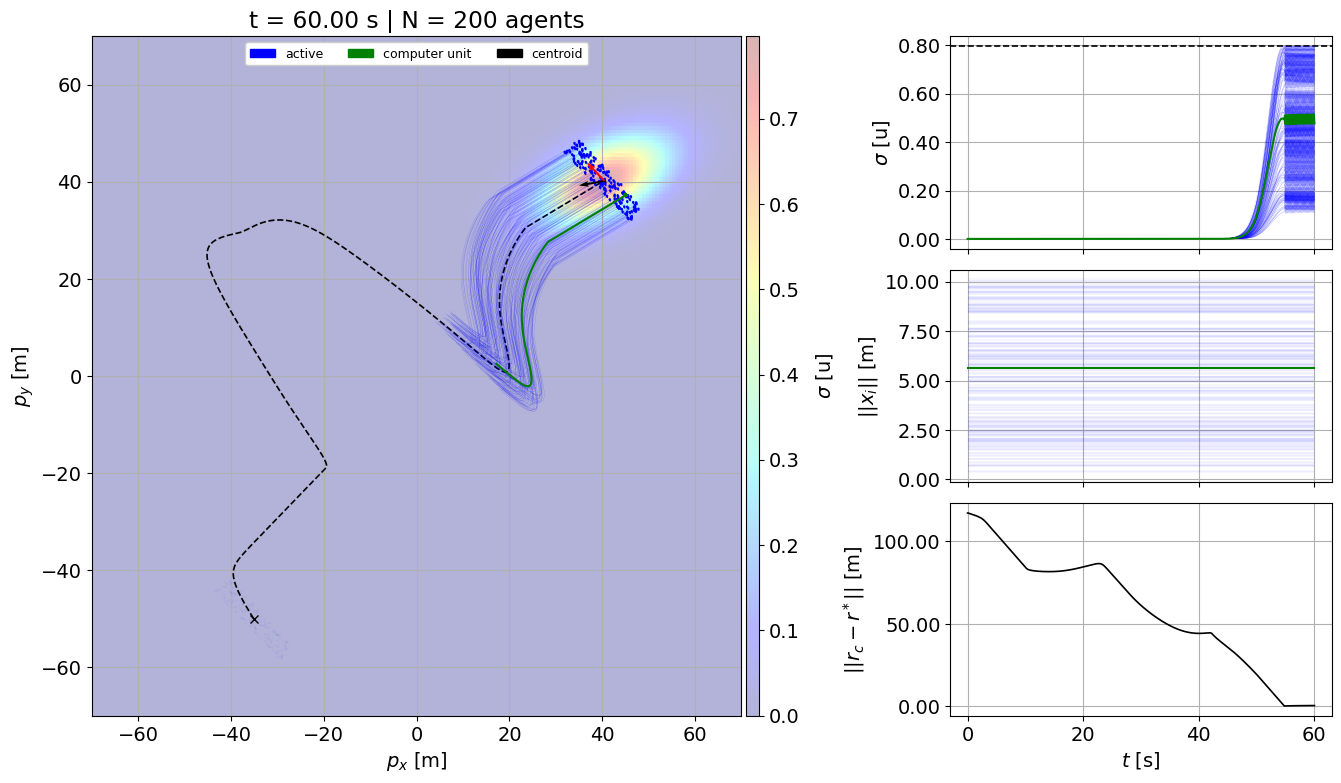

In [ ]:
"""
Mostramos el estado final de la simulación (static plot).
"""
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Comenzamos a graficar
# ----------------------------------------------------------------------

color_init = [palette[1] if n == sim.N-1 else (palette[0] if active_status[0,n] else palette[2]) for n in range(sim.N)]
color = [palette[1] if n == sim.N-1 else (palette[0] if sim.active[n] else palette[2]) for n in range(sim.N)]
lw = [lider_lw if n == sim.N-1 else (agents_active_lw if sim.active[n] else agents_dead_lw) for n in range(sim.N)]
z_order = [5 if n == sim.N-1 else (3 if sim.active[n] else 4) for n in range(sim.N)]

li = xdata.shape[0] - 1
legend_flags = [False, False, False]

# FIGURE init
# ----------------
fig = plt.figure(figsize=(16, 9), dpi=100)
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim([-xlim,xlim])
main_ax.set_ylim([-ylim,ylim])
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)


# MAIN_AXS
# ----------------
if field_rot is not None:
  sim.sigma_field.rot = field_rot[li]
sigma_field.draw(fig, main_ax, **kw_draw_field)

main_ax.set_title("t = {0:.2f} s | N = {1:d} agents".format(t_sim_final, sim.N))
main_ax.grid(True)

# Agentes
for n in range(sim.N):
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color_init[n])
  icon_init.set_alpha(alfa_init)
  icon = plt.Circle((xdata[li,n], ydata[li,n]), agents_cicle_rad, color=color[n])
  
  icon_init.set_zorder(z_order[n])
  icon.set_zorder(z_order[n])
  
  for i in range(len(palette)):
    if not legend_flags[i] and color[n] == palette[i]:
      icon.set_label(legend_labels[i])
      legend_flags[i] = True

  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  main_ax.plot(xdata[li-tail_frames:li,n],ydata[li-tail_frames:li,n], 
               c=color[n], ls="-", lw=lw[n], zorder=z_order[n])

# Centroide
icon_centroid = plt.Circle((rc_xdata[li], rc_ydata[li]), agents_cicle_rad*2, color="k")
main_ax.add_patch(icon_centroid)
icon_centroid.set_label(legend_labels[3])

main_ax.plot(rc_xdata[0],rc_ydata[0], "x", c="k")
main_ax.plot(rc_xdata[:],rc_ydata[:], c="k", ls="--", lw=1.2)

# Flecha gradiente
sigma_field.draw_grad([rc_xdata[li], rc_ydata[li]], main_ax, **arr_kw)
main_ax.quiver(rc_xdata[li], rc_ydata[li], l_sigma[li,0], l_sigma[li,1], 
               color=l_sigma_color, **arr_kw)

# Legenda
main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})


# DATA_AXS
# ----------------
time_vec = np.linspace(0, sim.get_tf(), int((sim.get_tf() + 11/10*sim.dt)/sim.dt))

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)

for n in range(sim.N):
  sigma_data_ax.plot(time_vec, sigma_data[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
  ddata_ax.plot(time_vec, ddata[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
edata_ax.plot(time_vec, edata[:], c="k", lw=1.2)

# Visualizamos el resultado :)
plt.show()

In [ ]:
"""
Animación de la simulación numérica.
"""

# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

figsize = np.array([16, 9])

# ----------------------------------------------------------------------
# Parámetros de la animación
# ----------------------------------------------------------------------

# Resolución de los frames de la animación
res = 480  
#res = 1920 # Full HD
res = 2560 # 2k
#res = 3880 # 4K

# Variables temporales
dt = sim.dt
anim_tf = sim.get_tf()
anim_frames = int((anim_tf + 11/10*sim.dt)/dt)
# anim_tf = 1
# anim_frames = 11

# Efecto zoom
min_zoom, max_zoom = 1.0, 1.1
min_zoom_t, max_zoom_t = 10, 40

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------
color = [palette[1] if n == sim.N-1 else (palette[0] if active_status[0,n] else palette[2]) for n in range(sim.N)]
lw = [lider_lw if n == sim.N-1 else (agents_active_lw if active_status[0,n] else agents_dead_lw) for n in range(sim.N)]
z_order = [5 if n == sim.N-1 else (3 if active_status[0,n] else 4) for n in range(sim.N)]

if min_zoom_t <= max_zoom_t:
  _min_z, _max_z = min_zoom, max_zoom
  _min_t, _max_t = min_zoom_t, max_zoom_t 
else:
  _min_z, _max_z = max_zoom, min_zoom
  _min_t, _max_t = max_zoom_t, min_zoom_t 


# FIGURE init
# ----------------
fig = plt.figure(figsize=figsize, dpi=res/figsize[0])
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim(rc_xdata[0] + np.array(_zoom_range(-xlim, xlim, 0, _min_z)))
main_ax.set_ylim(rc_ydata[0] + np.array(_zoom_range(-ylim, ylim, 0, _min_z)))
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")
main_ax.grid(True)

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)


# MAIN_AX init
# ----------------
if field_rot is not None:
  kw_draw_img = {key: kw_draw_field[key] for key in kw_draw_field.keys() if key != "contour_levels"}
  sim.sigma_field.rot = field_rot[0]
  field_img = sigma_field.draw_imshow(fig, main_ax, **kw_draw_img)
else:
  sigma_field.draw(fig, main_ax, **kw_draw_field)

# Agentes
lines_agents = []
icons_agents = []
legend_flags = [False, False, False]
for n in range(sim.N):
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color[n])
  icon_init.set_alpha(alfa_init)
  icon = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color[n])
  
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[0,n], ydata[0,n], c=color[n], ls="-", lw=lw[n])

  for i in range(len(palette)):
    if not legend_flags[i] and color[n] == palette[i]:
      icon.set_label(legend_labels[i])
      legend_flags[i] = True
  
  lines_agents.append(line)
  icons_agents.append(icon)

# Centroides
lines_centroids = []
icons_centroids = []

line, = main_ax.plot(rc_xdata[0], rc_ydata[0], c="k", ls="--", lw=1.2)
icon_centroid = plt.Circle((rc_xdata[0], rc_ydata[0]), agents_cicle_rad*2, color="k")
icon_centroid.set_label(legend_labels[3])

main_ax.add_patch(icon_centroid)
main_ax.plot(rc_xdata[0],rc_ydata[0], "x", c="k")

lines_centroids.append(line)
icons_centroids.append(icon_centroid)

# Flecha gradiente
q_grad = sigma_field.draw_grad([rc_xdata[0], rc_ydata[0]], main_ax, **arr_kw)
q_Lsig = main_ax.quiver(rc_xdata[0], rc_ydata[0], l_sigma[0,0], l_sigma[0,1], 
                        color=l_sigma_color, **arr_kw)

# Leyenda y título
main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})
txt_title = main_ax.set_title("")


# DATA_AXS init
# ----------------
time_vec = np.linspace(0, anim_tf, anim_frames)

data_lines_plt = []
sigma_lines_data = []
ddata_lines_data = []
for n in range(sim.N):
  kw = dict(c=color[n], lw=lw[n])
  sigma_line_data, = sigma_data_ax.plot(time_vec, sigma_data[0:len(time_vec),n], c=color[n], lw=lw[n])
  ddata_line_data, = ddata_ax.plot(time_vec, ddata[0:len(time_vec),n], c=color[n], lw=lw[n])
  sigma_lines_data.append(sigma_line_data)
  ddata_lines_data.append(ddata_line_data)
edata_ax.plot(time_vec, edata[0:len(time_vec)], c="k", lw=1.2)

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)
sigma_line = sigma_data_ax.axvline(0, c="k", ls="--", lw=1.2)
dline = ddata_ax.axvline(0, c="k", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="k", ls="--", lw=1.2)

# ----------------------------------------------------------------------
# Comenzamos la animación de la simulación
# ----------------------------------------------------------------------

# Función para actualizar la animación
def animate(i):
  color = [palette[1] if n == sim.N-1 else (palette[0] if active_status[i,n] else palette[2]) for n in range(sim.N)]
  lw = [lider_lw if n == sim.N-1 else (agents_active_lw if active_status[i,n] else agents_dead_lw) for n in range(sim.N)]
  z_order = [5 if n == sim.N-1 else (3 if active_status[i,n] else 4) for n in range(sim.N)]

  # Actualizamos el campo si es necesario
  if field_rot is not None:
    sim.sigma_field.rot = field_rot[i]
    Z = sigma_field.draw_imshow(**kw_draw_img, make_im=False)
    field_img.set_data(Z) 

  # Agentes
  for n in range(sim.N):
    icons_agents[n].remove()
    icons_agents[n] = plt.Circle((xdata[i,n], ydata[i,n]), agents_cicle_rad, color=color[n])

    icons_agents[n].set_zorder(z_order[n])
    icon_init.set_zorder(z_order[n])
    lines_agents[n].set_zorder(z_order[n])
    lines_agents[n].set_color(color[n])
    sigma_lines_data[n].set_color(color[n])
    ddata_lines_data[n].set_color(color[n])

    if i > tail_frames:
      lines_agents[n].set_data(xdata[i-tail_frames:i,n], ydata[i-tail_frames:i,n])
    else:
      lines_agents[n].set_data(xdata[0:i,n], ydata[0:i,n])
    main_ax.add_patch(icons_agents[n])

  # Icono y línea del centroide
  icons_centroids[0].remove()
  icons_centroids[0] = plt.Circle((rc_xdata[i], rc_ydata[i]), 0.1, color="k")
  icons_centroids[0].set_zorder(6)

  lines_centroids[0].set_data(rc_xdata[0:i], rc_ydata[0:i])
  main_ax.add_patch(icons_centroids[0])

  # Flechas
  if edata[i] > thr_arrows:
    q_grad.set_offsets(np.array([rc_xdata[i], rc_ydata[i]]).T)
    q_Lsig.set_offsets(np.array([rc_xdata[i], rc_ydata[i]]).T)
    q_grad.set_UVC(rc_grad[i,0], rc_grad[i,1])
    q_Lsig.set_UVC(l_sigma[i,0], l_sigma[i,1])
  else:
    q_grad.set_offsets(np.array([2*xlim, 2*ylim]).T)
    q_Lsig.set_offsets(np.array([2*xlim, 2*ylim]).T)

  # string format: https://www.w3schools.com/python/ref_string_format.asp
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s | N = {2:>4} agents'.format(i, i*dt, sim.N))

  sigma_line.set_xdata(i*dt)
  dline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Efecto zoom
  if (i*dt < _min_t):
    zoom = _min_z
  elif (i*dt >= _min_t) and (i*dt <= _max_t):
    zoom = _min_z + (_max_z - _min_z) * (i*dt - _min_t)/(_max_t - _min_t)
  else:
    zoom = _min_z + (_max_z - _min_z)
  main_ax.set_xlim(0 + sim.sigma_field.mu[0]/2 * i/anim_frames + 
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))
  main_ax.set_ylim(0 + sim.sigma_field.mu[1]/2 * i/anim_frames + 
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((anim_frames-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(anim_frames-1)))

# Generamos la animación
print("Simulando {0:d} frames... \nEstado:".format(anim_frames))
anim = FuncAnimation(fig, animate, frames=anim_frames, interval=1000/60)
plt.close()

# Visualizamos la animación
anim.embed_limit = 40
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

Simulando 601 frames... 
Estado:
tf =  0.00 | 0.00%
tf =  0.00 | 0.00%


CalledProcessError: ignored

## (WIP) Simulación tipo 2: Varios clusters con una misma misión

Estas simulaciones continuan con la dinámica de single integrator pero ahora podemos tener varios clusters.

### SIM 4: Varios clusters en busca de la fuente

### Graficación compatible con las simulaciones tipo 2

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

delta = 0.8
agents_cicle_rad = 0.1
agents_active_lw = 0.2
agents_dead_lw = 1.0
lider_lw  = 1.4

color = ["r" if n == sim.N-1 else ("b" if sim.active[n] else "grey") for n in range(sim.N)]
lw = [lider_lw if n == sim.N-1 else (agents_active_lw if sim.active[n] else agents_dead_lw) for n in range(sim.N)]
z_order = [5 if n == sim.N-1 else (3 if sim.active[n] else 4) for n in range(sim.N)]

tmid = 15
lmid = int(17/sim.dt)

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(16, 9), dpi=100)
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$e$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)

# -------------
# Main ax init
# -------------
sigma_field.draw(fig, main_ax, xlim=50, ylim=50)
main_ax.set_title("t = {0:.2f} s | N = {1:d} agents".format(t_sim_final, sim.N))
main_ax.grid(True)

li = xdata.shape[0] - 1
for n in range(sim.N):
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color[n])
  icon_init.set_alpha(0.3)
  icon = plt.Circle((xdata[li,n], ydata[li,n]), agents_cicle_rad, color=color[n])
  
  icon_init.set_zorder(z_order[n])
  icon.set_zorder(z_order[n])

  if n == 1:
    icon.set_label("slave")
  if n == int(sim.N-1):
    icon.set_label("computer unit")

  main_ax.plot(xdata[:,n],ydata[:,n], c=color[n], ls="-", lw=lw[n], zorder=z_order[n])
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

cluster_rad = np.max(ddata[li,:]) + delta
icon_cluster = plt.Circle((rc_xdata[li], rc_ydata[li]), cluster_rad, alpha=0.2, color="grey")
cluster_rad = np.max(ddata[lmid,:]) + delta
icon_cluster_mid = plt.Circle((rc_xdata[lmid], rc_ydata[lmid]), cluster_rad, alpha=0.2, color="grey")

main_ax.plot(rc_xdata[0],rc_ydata[0], "x", c="k")
main_ax.plot(rc_xdata[:],rc_ydata[:], c="k", ls="--", lw=agents_active_lw)
main_ax.scatter(rc_xdata[li], rc_ydata[li], c="k", s=10)
main_ax.add_patch(icon_cluster)
main_ax.add_patch(icon_cluster_mid)

main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, sim.get_tf(), int(sim.get_tf()/sim.dt))

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="black", ls="--", lw=1.2)

for n in range(sim.N):
  sigma_data_ax.plot(time_vec, sigma_data[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
  ddata_ax.plot(time_vec, ddata[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
edata_ax.plot(time_vec, edata[:], c="k", lw=lw[n])

plt.show()

In [ ]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

test = True
figsize = np.array([16, 9])
if test:
  dpi = 480/16 #480p frames
else:
  dpi = 1080/16  # Full HD frames
  #dpi = 3880/16  #4K frames

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

delta = 0.8
agents_cicle_rad = 0.1
agents_active_lw = 0.2
agents_dead_lw = 1.0
lider_lw  = 1.4

color = ["r" if n == sim.N-1 else ("b" if active_status[0,n] else "grey") for n in range(sim.N)]
lw = [lider_lw if n == sim.N-1 else (agents_active_lw if active_status[0,n] else agents_dead_lw) for n in range(sim.N)]
z_order = [5 if n == sim.N-1 else (3 if active_status[0,n] else 4) for n in range(sim.N)]

# Límites de la gráfica y efecto zoom
xlim, ylim = 30, 30 # es escala 1.0
min_zoom, max_zoom = 1.0, 3.0
min_zoom_t, max_zoom_t = 30, 10

if min_zoom_t < max_zoom_t:
  _min_z, _max_z = min_zoom, max_zoom
  _min_t, _max_t = min_zoom_t, max_zoom_t 
else:
  _min_z, _max_z = max_zoom, min_zoom
  _min_t, _max_t = max_zoom_t, min_zoom_t 

t_fin_anim = sim.get_tf()
dt = sim.dt

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(3, 5, hspace=0.1, wspace=2)
main_ax       = fig.add_subplot(grid[:, 0:3])
sigma_data_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[1, 3:5], xticklabels=[])
edata_ax      = fig.add_subplot(grid[2, 3:5])

# Configuración de los ejes
main_ax.set_xlim(rc_xdata[0] + np.array(_zoom_range(-xlim, xlim, 0, _min_z)))
main_ax.set_ylim(rc_ydata[0] + np.array(_zoom_range(-ylim, ylim, 0, _min_z)))
main_ax.set_ylabel(r"$p_y$ [m]")
main_ax.set_xlabel(r"$p_x$ [m]")

sigma_data_ax.set_ylabel(r"$\sigma$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [m]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [s]")
edata_ax.set_ylabel(r"$e$ [m]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.grid(True)

# -------------
# Main ax init
# -------------
sigma_field.draw(fig, main_ax, xlim=70, ylim=70)
main_ax.grid(True)

# Agentes
lines_agents = []
icons_agents = []
for n in range(sim.N):
  icon_init = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color[n])
  icon_init.set_alpha(0.3)
  icon = plt.Circle((xdata[0,n], ydata[0,n]), agents_cicle_rad, color=color[n])
  
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[0,n], ydata[0,n], c=color[n], ls="-", lw=lw[n])

  if n == 1:
    icon.set_label("slave")
  if n == int(sim.N-1):
    icon.set_label("computer unit")
    icon_init.set_zorder(3)
    icon.set_zorder(3)
  
  lines_agents.append(line)
  icons_agents.append(icon)

# Centroides y clusters
lines_centroids = []
icons_centroids = []
icons_clusters  = []

cluster_rad = np.max(ddata[0,:]) + delta

line, = main_ax.plot(rc_xdata[0], rc_ydata[0], c="k", ls="--", lw=1.2)
icon_centroid_init = plt.Circle((rc_xdata[0], rc_ydata[0]), 0.1, alpha=0.3, color="k")
icon_centroid = plt.Circle((rc_xdata[0], rc_ydata[0]), 0.1, color="k")
icon_cluster = plt.Circle((rc_xdata[0], rc_ydata[0]), cluster_rad, alpha=0.2, color="grey")

main_ax.add_patch(icon_centroid_init)
main_ax.add_patch(icon_centroid)
main_ax.add_patch(icon_cluster)

lines_centroids.append(line)
icons_centroids.append(icon_centroid)
icons_clusters.append(icon_cluster)

# Leyenda y título
main_ax.legend(loc="upper center", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_fin_anim, int(t_fin_anim/dt))
data_lines_plt = []
for n in range(sim.N):
  kw = dict(c=color[n], lw=lw[n])
  sigma_data_ax.plot(time_vec, sigma_data[:,n], **kw)
  ddata_ax.plot(time_vec, ddata[:,n], **kw)
  edata_ax.plot(time_vec, edata[:], **kw)

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="black", ls="--", lw=1.2)
sigma_line = sigma_data_ax.axvline(0, c="black", ls="--", lw=1.2)
dline = ddata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_agents[n].remove()
    icons_agents[n] = plt.Circle((xdata[i,n], ydata[i,n]), agents_cicle_rad, color=color[n])

    icons_agents[n].set_zorder(z_order[n])
    icon_init.set_zorder(z_order[n])
    lines_agents[n].set_zorder(z_order[n])

    lines_agents[n].set_data(xdata[0:i,n], ydata[0:i,n])
    main_ax.add_patch(icons_agents[n])
  
  # En esta simulación no tiene sentido el bucle, 
  # pero será interesante cuando tengamos varios clusters
  for k in range(len(lines_centroids)):
    icons_centroids[k].remove()
    icons_centroids[k] = plt.Circle((rc_xdata[i], rc_ydata[i]), 0.1, color="k")
    icons_centroids[k].set_zorder(6)

    cluster_rad = np.max(ddata[i,:]) + delta
    icons_clusters[k].remove()
    icons_clusters[k] = plt.Circle((rc_xdata[i], rc_ydata[i]), cluster_rad, alpha=0.2, color="grey")

    lines_centroids[k].set_data(rc_xdata[0:i], rc_ydata[0:i])
    main_ax.add_patch(icons_centroids[k])
    main_ax.add_patch(icons_clusters[k])

  # string format: https://www.w3schools.com/python/ref_string_format.asp
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s | N = {2:>4} agents'.format(i, i*dt, sim.N))

  sigma_line.set_xdata(i*dt)
  dline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Efecto zoom
  if (i*dt < _min_t):
    zoom = _min_z
  elif (i*dt >= _min_t) and (i*dt <= _max_t):
    zoom = _min_z + (_max_z - _min_z) * (i*dt - _min_t)/(_max_t - _min_t)
  else:
    zoom = _min_z + (_max_z - _min_z)
  main_ax.set_xlim(rc_xdata[i] + np.array(_zoom_range(-xlim, xlim, 0, zoom)))
  main_ax.set_ylim(rc_ydata[i] + np.array(_zoom_range(-ylim, ylim, 0, zoom)))

  # Mostramos el porcentaje de carga de la simulación
  if ((i*dt) % 10 == 0):
    progress_perc = i*dt/(t_fin_anim-dt) if i*dt > 0 else 0
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, progress_perc))

# Generamos la animación y la visualizamos
print("Simulando {0:d} frames... \nEstado:".format(int(t_fin_anim/dt)))
anim = FuncAnimation(fig, animate, frames=int(t_fin_anim/dt), interval=20)
plt.close()

# Visualizamos la animación
anim.embed_limit = 40
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

Simulando 501 frames... 
Estado:
tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf = 10.00 | 20.00%
tf = 20.00 | 40.00%
tf = 30.00 | 60.00%
tf = 40.00 | 80.00%
tf = 50.00 | 100.00%


## Simulación tipo 3: Uniciclos en busca de la fuente

Similir a la simulación tipo 1, pero con dinámica de uniciclos

In [10]:
# ----------------------------------------------------------------------
# Simulation 3 class 
# ----------------------------------------------------------------------

"""
Simulation 3
  * x0: Vector de parámetros iniciales [t0,p0,v0,phi0]
    - t0: tiempo inicial de la simulación
    - p0: matriz con la posición inicial de cada agente.
    - v0: velocidad constante para todos los agentes.
    - phi0: heading inicial de cada uniciclo.
"""
class arquimides_sim3:
  def __init__(self, sigma_field, n_agents, x0, dt = 0.01, kd = 0.5):
    self.N = n_agents
    self.dt = dt
    
    # Generamos el simulation frame
    self.sim_frame = sim_frame(self.N, [x0[0],x0[1],x0[3]], self.dt)

    # Estados de esta simulación
    self.vf = x0[2]                                      # Velocidad común constante
    self.omega_i = np.zeros(self.N)                    # Acción de control
    self.sigma_field = sigma_field                     # Clase campo escalar 
    self.sigma = self.sigma_field.value(x0[1])            # Sigmas medidos (N x 1)

    self.rc = np.mean(x0[1], axis=0)   
    self.rc_e = la.norm(self.rc - self.sigma_field.mu) # Distancia hasta la fuente
    self.rc_sigma = self.sigma_field.value(self.rc)[0] # Sigma en el centroide
    self.X = x0[1] - self.rc                           # Geometría del enjambre
    self.d = la.norm(self.X, axis=1)                   # Distancia al centroide

    self.l_sigma_hat = np.zeros(2)
    self.rc_grad = self.sigma_field.grad(self.rc)[0]

    # Parámetros del controlador GVF
    self.kd = kd

  """
  Extraer los resultados de la simulación.
  """
  def get_tf(self):
    return self.sim_frame.tf

  def get_pf(self):
    return self.sim_frame.states[0]

  def get_phif(self):
    return self.sim_frame.states[1]

  """
  Calcular l_sigma_hat.
  """
  def LsigmaHat(self, X):
    l_sigma_hat = self.sim_frame.L_sigma(X, self.sigma)
    l_sigma_hat_norm = la.norm(l_sigma_hat)
    if l_sigma_hat_norm != 0:
      return l_sigma_hat / l_sigma_hat_norm
    else:
      return np.zeros(2)

  """
  Controlador GVF classic asumiendo omega_d = 0
  """
  def gvf_control(self):
    phi = self.get_phif()
    vel_hat = np.array([np.cos(phi), np.sin(phi)]).T
    omega = - self.kd * angle_of_vectors(self.l_sigma_hat * np.ones((self.N,2)), vel_hat)
    return omega

  """
  Dinámica libre que sigue dirección de ascenso (celeridad constante)
    * X: matriz de distancias relativas al centroide (N x n) xi = [px, py, pz]
    * sigma: vector con las medidas de sigma_field de cada agente (N x 1)
  """
  def unicycle_kinematics(self):
    phi = self.get_phif()
    p_dot = self.vf * np.array([np.cos(phi), np.sin(phi)]).T
    phi_dot = self.omega_i
    return p_dot, phi_dot

  def shape_control(self):
    return (self.Xd - self.X)/10

  """
  Integración paso a paso.
  """
  def int_step(self):
    self.rc = np.mean(self.get_pf(), axis=0) 
    self.rc_e = la.norm(self.rc - self.sigma_field.mu)
    self.rc_sigma = self.sigma_field.value(self.rc)[0]
    self.rc_grad = self.sigma_field.grad(self.rc)[0]
    self.rc_grad = self.rc_grad/la.norm(self.rc_grad)

    self.X = self.get_pf() - self.rc
    self.d = la.norm(self.X, axis=1)
    self.sigma = self.sigma_field.value(self.get_pf())

    # Calculamos x_dot y se lo pasamos al sim_frame
    self.l_sigma_hat = self.LsigmaHat(self.X)
    self.omega_i = self.gvf_control()
    x_dot = self.unicycle_kinematics()
    self.sim_frame.int_euler(x_dot)

### SIM 6: Uniciclos en busca de la fuente

In [83]:
# ----------------------------------------------------------------------
# Generamos el campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.2
t0 = 0
t_sim_final = 200

# Estado inicial de los agentes y número de agentes
n_agents = 20
rc0 = [-35, -50]
r, h = 10, 2
lims = [15, 2]
border_noise = 0.6

p0_cir = circular_distrib(n_agents, n, [0,0], r, h, border_noise)
p0_sqr = XY_distrib(n_agents, n, [0,0], lims, border_noise)

p0 = rc0 + p0_sqr
v0 = 1.2
phi0 = np.random.rand(n_agents) * np.pi

kd = 0.2

In [84]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = arquimides_sim3(sigma_field, n_agents, [t0, p0, v0, phi0], dt, kd)

# Realizamos toda la simulación mumerica
xdata, ydata = [sim.get_pf()[:,0]], [sim.get_pf()[:,1]]
phidata =[sim.get_phif()]
rc_xdata, rc_ydata = [sim.rc[0]], [sim.rc[1]]
edata, ddata = [sim.rc_e], [sim.d]
sigma_data = [sim.sigma]
omega_data = [sim.omega_i]
l_sigma = [sim.l_sigma_hat]
rc_grad = [sim.rc_grad]
field_rot = None # Campo no rota

while (sim.get_tf() <= t_sim_final - dt/10):
  if (sim.get_tf() >= 5) and (sim.get_tf() <= 11):
    sim.Xd = p0_sqr

  sim.int_step()

  xdata.append(sim.get_pf()[:,0])
  ydata.append(sim.get_pf()[:,1])
  phidata.append(sim.get_phif())
  rc_xdata.append(sim.rc[0])
  rc_ydata.append(sim.rc[1])

  edata.append(sim.rc_e)
  ddata.append(sim.d)
  sigma_data.append(sim.sigma)
  omega_data.append(sim.omega_i)

  l_sigma.append(sim.l_sigma_hat)
  rc_grad.append(sim.rc_grad)

print("tf:", sim.get_tf())

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)
rc_xdata = np.array(rc_xdata)
rc_ydata = np.array(rc_ydata)
edata = np.array(edata)
ddata = np.array(ddata)
sigma_data = np.array(sigma_data)
omega_data = np.array(omega_data)
l_sigma = np.array(l_sigma)
rc_grad = np.array(rc_grad)

tf: 199.9999999999972


### Graficación compatible con las simulaciones tipo 3

In [66]:
palette = ["b", "green", "r"]
legend_labels = ["active", "computer unit", "non-active", "centroid"]
figsize = np.array([16, 9])

delta = 0.8
agents_cicle_rad = 0.12
agents_active_lw = 0.15
lw_centroid = 0.9
lider_lw  = 1.5

alfa_init = 0.2
tail_time = 20

# Tamaño de los iconos
kw_patch = {"size":1.5, "lw":0.5}

# Dimensiones de las flechas
l_sigma_color = "red"
arr_kw = {"width":0.003, "scale":25, "zorder":10}
thr_arrows = -1

# Límites de la gráfica en ambos casos
xlim, ylim = 70, 70
kw_draw_field = {"xlim":2*xlim, "ylim":2*ylim, "n":300, "contour_levels":20}

# Cálculos con estos parámetros que servirán para static plot y animación
tail_frames = int(tail_time/sim.dt)

color_init = [palette[0] for n in range(sim.N)]
color = [palette[0] for n in range(sim.N)]
lw = [agents_active_lw for n in range(sim.N)]
z_order = [3 for n in range(sim.N)]

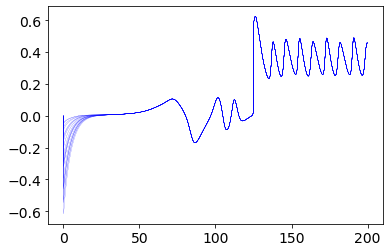

In [87]:
time_vec = np.linspace(0, sim.get_tf(), int((sim.get_tf() + 11/10*sim.dt)/sim.dt))
for n in range(sim.N):
  plt.plot(time_vec, omega_data[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
plt.show()

In [ ]:
# fig = plt.figure(figsize=(9, 9), dpi=120)
# ax = fig.subplots()
# sigma_field.draw(fig, ax, **kw_draw_field)
# for i in range(int(len(rc_xdata)/24)):
#   frame = i*24
#   ax.quiver(rc_xdata[frame], rc_ydata[frame], rc_grad[frame,0], rc_grad[frame,1], color="k", width=0.0015, scale=70)
# plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

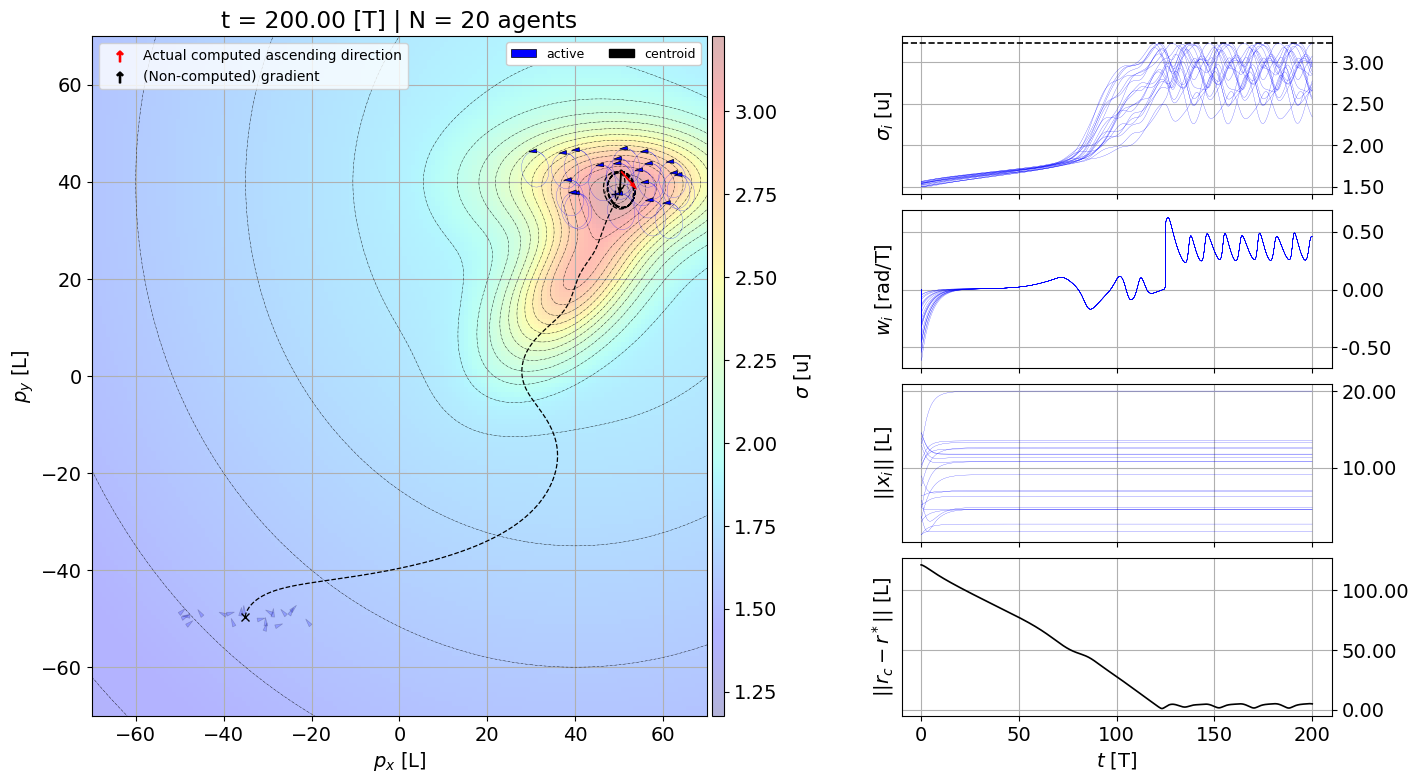

In [101]:
"""
Mostramos el estado final de la simulación (static plot).
"""
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Comenzamos a graficar
# ----------------------------------------------------------------------
li = xdata.shape[0] - 1
legend_flags = [False, False, False]

# FIGURE init
# ----------------
fig = plt.figure(figsize=figsize, dpi=100)
grid = plt.GridSpec(4, 7, hspace=0.1, wspace=7)
main_ax       = fig.add_subplot(grid[:, 0:4])
sigma_data_ax = fig.add_subplot(grid[0, 4:8], xticklabels=[])
omega_data_ax = fig.add_subplot(grid[1, 4:8], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[2, 4:8], xticklabels=[])
edata_ax      = fig.add_subplot(grid[3, 4:8])

# Configuración de los ejes
main_ax.set_xlim([-xlim,xlim])
main_ax.set_ylim([-ylim,ylim])
main_ax.set_ylabel(r"$p_y$ [L]")
main_ax.set_xlabel(r"$p_x$ [L]")

sigma_data_ax.set_ylabel(r"$\sigma_i$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.yaxis.tick_right()
sigma_data_ax.grid(True)
omega_data_ax.set_ylabel(r"$w_i$ [rad/T]")
omega_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
omega_data_ax.yaxis.tick_right()
omega_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [L]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.yaxis.tick_right()
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [T]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [L]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.yaxis.tick_right()
edata_ax.grid(True)


# MAIN_AXS
# ----------------
if field_rot is not None:
  sim.sigma_field.rot = field_rot[li]
sigma_field.draw(fig, main_ax, **kw_draw_field)

main_ax.set_title("t = {0:.2f} [T] | N = {1:d} agents".format(t_sim_final, sim.N))
main_ax.grid(True)

# Agentes
for n in range(sim.N):
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color_init[n], **kw_patch)
  icon_init.set_alpha(alfa_init)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color[n], **kw_patch)
  
  icon_init.set_zorder(z_order[n])
  icon.set_zorder(z_order[n])
  
  for i in range(len(palette)):
    if not legend_flags[i] and color[n] == palette[i]:
      icon.set_label(legend_labels[i])
      legend_flags[i] = True

  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  main_ax.plot(xdata[li-tail_frames:li,n],ydata[li-tail_frames:li,n], 
               c=color[n], ls="-", lw=lw[n], zorder=z_order[n])

# Centroide
icon_centroid = plt.Circle((rc_xdata[li], rc_ydata[li]), agents_cicle_rad*2, color="k")
main_ax.add_patch(icon_centroid)
icon_centroid.set_label(legend_labels[3])

main_ax.plot(rc_xdata[0],rc_ydata[0], "x", c="k")
main_ax.plot(rc_xdata[:],rc_ydata[:], c="k", ls="--", lw=lw_centroid)

# Flecha gradiente
q_grad = sigma_field.draw_grad([rc_xdata[li], rc_ydata[li]], main_ax, **arr_kw)
q_Lsig = main_ax.quiver(rc_xdata[li], rc_ydata[li], l_sigma[li,0], l_sigma[li,1], 
                        color=l_sigma_color, **arr_kw)

# Legendas
main_ax.legend(loc="upper right", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})

arr1 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
arr2 = plt.scatter([],[],c='k'  ,marker=r'$\uparrow$',s=60)
leg = Legend(main_ax, [arr1, arr2], ["Actual computed ascending direction", "(Non-computed) gradient"], 
             loc="upper left", prop={'size': 10})
main_ax.add_artist(leg)

# DATA_AXS
# ----------------
time_vec = np.linspace(0, sim.get_tf(), int((sim.get_tf() + 11/10*sim.dt)/sim.dt))

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)

for n in range(sim.N):
  sigma_data_ax.plot(time_vec, sigma_data[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
  omega_data_ax.plot(time_vec, omega_data[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
  ddata_ax.plot(time_vec, ddata[:,n], c=color[n], lw=lw[n], zorder=z_order[n])
edata_ax.plot(time_vec, edata[:], c="k", lw=1.2)

# Visualizamos el resultado :)
plt.show()

In [ ]:
"""
Animación de la simulación numérica.
"""

# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Parámetros de la animación
# ----------------------------------------------------------------------

# Resolución de los frames de la animación
res = 480  
res = 1920 # Full HD
res = 2560 # 2k
#res = 3880 # 4K

# Variables temporales
dt = sim.dt
anim_tf = sim.get_tf()
anim_frames = int((anim_tf + 11/10*sim.dt)/dt)
# anim_tf = 1
# anim_frames = 11

# Efecto zoom
min_zoom, max_zoom = 1.0, 1.1
min_zoom_t, max_zoom_t = 10, 40

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------
if min_zoom_t <= max_zoom_t:
  _min_z, _max_z = min_zoom, max_zoom
  _min_t, _max_t = min_zoom_t, max_zoom_t 
else:
  _min_z, _max_z = max_zoom, min_zoom
  _min_t, _max_t = max_zoom_t, min_zoom_t 


# FIGURE init
# ----------------
fig = plt.figure(figsize=figsize, dpi=res/figsize[0])
grid = plt.GridSpec(4, 7, hspace=0.1, wspace=7)
main_ax       = fig.add_subplot(grid[:, 0:4])
sigma_data_ax = fig.add_subplot(grid[0, 4:8], xticklabels=[])
omega_data_ax = fig.add_subplot(grid[1, 4:8], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[2, 4:8], xticklabels=[])
edata_ax      = fig.add_subplot(grid[3, 4:8])

# Configuración de los ejes
main_ax.set_xlim([-xlim,xlim])
main_ax.set_ylim([-ylim,ylim])
main_ax.set_ylabel(r"$p_y$ [L]")
main_ax.set_xlabel(r"$p_x$ [L]")

sigma_data_ax.set_ylabel(r"$\sigma_i$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.yaxis.tick_right()
sigma_data_ax.grid(True)
omega_data_ax.set_ylabel(r"$w_i$ [rad/T]")
omega_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
omega_data_ax.yaxis.tick_right()
omega_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [L]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.yaxis.tick_right()
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [T]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [L]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.yaxis.tick_right()
edata_ax.grid(True)


# MAIN_AX init
# ----------------
if field_rot is not None:
  kw_draw_img = {key: kw_draw_field[key] for key in kw_draw_field.keys() if key != "contour_levels"}
  sim.sigma_field.rot = field_rot[0]
  field_img = sigma_field.draw_imshow(fig, main_ax, **kw_draw_img)
else:
  sigma_field.draw(fig, main_ax, **kw_draw_field)

# Agentes
lines_agents = []
icons_agents = []
legend_flags = [False, False, False]
for n in range(sim.N):
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color_init[n])
  icon_init.set_alpha(alfa_init)
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color[n])
  
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[0,n], ydata[0,n], c=color[n], ls="-", lw=lw[n])

  for i in range(len(palette)):
    if not legend_flags[i] and color[n] == palette[i]:
      icon.set_label(legend_labels[i])
      legend_flags[i] = True
  
  lines_agents.append(line)
  icons_agents.append(icon)

# Centroides
lines_centroids = []
icons_centroids = []

line, = main_ax.plot(rc_xdata[0], rc_ydata[0], c="k", ls="--", lw=lw_centroid)
icon_centroid = plt.Circle((rc_xdata[0], rc_ydata[0]), agents_cicle_rad*2, color="k")
icon_centroid.set_label(legend_labels[3])

main_ax.add_patch(icon_centroid)
main_ax.plot(rc_xdata[0],rc_ydata[0], "x", c="k")

lines_centroids.append(line)
icons_centroids.append(icon_centroid)

# Flecha gradiente
q_grad = sigma_field.draw_grad([rc_xdata[0], rc_ydata[0]], main_ax, **arr_kw)
q_Lsig = main_ax.quiver(rc_xdata[0], rc_ydata[0], l_sigma[0,0], l_sigma[0,1], 
                        color=l_sigma_color, **arr_kw)

# Leyenda y título
main_ax.legend(loc="upper right", ncol=sim.N, 
               fancybox=True, framealpha=1, prop={'size': 9})

arr1 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
arr2 = plt.scatter([],[],c='k'  ,marker=r'$\uparrow$',s=60)
leg = Legend(main_ax, [arr1, arr2], ["Actual computed ascending direction", "(Non-computed) gradient"], 
             loc="upper left", prop={'size': 10})
main_ax.add_artist(leg)

txt_title = main_ax.set_title("")


# DATA_AXS init
# ----------------
time_vec = np.linspace(0, anim_tf, anim_frames)

data_lines_plt = []
sigma_lines_data = []
omega_lines_data = []
ddata_lines_data = []
for n in range(sim.N):
  kw = dict(c=color[n], lw=lw[n])
  sigma_line_data, = sigma_data_ax.plot(time_vec, sigma_data[0:len(time_vec),n], c=color[n], lw=lw[n])
  ddata_line_data, = ddata_ax.plot(time_vec, ddata[0:len(time_vec),n], c=color[n], lw=lw[n])
  omega_line_data, = omega_data_ax.plot(time_vec, omega_data[0:len(time_vec),n], c=color[n], lw=lw[n])
  sigma_lines_data.append(sigma_line_data)
  omega_lines_data.append(omega_line_data)
  ddata_lines_data.append(ddata_line_data)
edata_ax.plot(time_vec, edata[0:len(time_vec)], c="k", lw=1.2)

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)
sigma_line = sigma_data_ax.axvline(0, c="k", ls="--", lw=1.2)
omega_line = omega_data_ax.axvline(0, c="k", ls="--", lw=1.2)
dline = ddata_ax.axvline(0, c="k", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="k", ls="--", lw=1.2)

# ----------------------------------------------------------------------
# Comenzamos la animación de la simulación
# ----------------------------------------------------------------------

# Función para actualizar la animación
def animate(i):
  # Actualizamos el campo si es necesario
  if field_rot is not None:
    sim.sigma_field.rot = field_rot[i]
    Z = sigma_field.draw_imshow(**kw_draw_img, make_im=False)
    field_img.set_data(Z) 

  # Agentes
  for n in range(sim.N):
    icons_agents[n].remove()
    icons_agents[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], color_init[n])
    main_ax.add_patch(icons_agents[n])

    if i > tail_frames:
      lines_agents[n].set_data(xdata[i-tail_frames:i,n], ydata[i-tail_frames:i,n])
    else:
      lines_agents[n].set_data(xdata[0:i,n], ydata[0:i,n])

  # Icono y línea del centroide
  icons_centroids[0].remove()
  icons_centroids[0] = plt.Circle((rc_xdata[i], rc_ydata[i]), 0.1, color="k")
  icons_centroids[0].set_zorder(6)

  lines_centroids[0].set_data(rc_xdata[0:i], rc_ydata[0:i])
  main_ax.add_patch(icons_centroids[0])

  # Flechas
  if edata[i] > thr_arrows:
    q_grad.set_offsets(np.array([rc_xdata[i], rc_ydata[i]]).T)
    q_Lsig.set_offsets(np.array([rc_xdata[i], rc_ydata[i]]).T)
    q_grad.set_UVC(rc_grad[i,0], rc_grad[i,1])
    q_Lsig.set_UVC(l_sigma[i,0], l_sigma[i,1])
  else:
    q_grad.set_offsets(np.array([2*xlim, 2*ylim]).T)
    q_Lsig.set_offsets(np.array([2*xlim, 2*ylim]).T)

  # string format: https://www.w3schools.com/python/ref_string_format.asp
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s | N = {2:>4} agents'.format(i, i*dt, sim.N))

  sigma_line.set_xdata(i*dt)
  omega_line.set_xdata(i*dt)
  dline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Efecto zoom
  if (i*dt < _min_t):
    zoom = _min_z
  elif (i*dt >= _min_t) and (i*dt <= _max_t):
    zoom = _min_z + (_max_z - _min_z) * (i*dt - _min_t)/(_max_t - _min_t)
  else:
    zoom = _min_z + (_max_z - _min_z)
  main_ax.set_xlim(0 + sim.sigma_field.mu[0]/2 * i/anim_frames + 
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))
  main_ax.set_ylim(0 + sim.sigma_field.mu[1]/2 * i/anim_frames + 
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((anim_frames-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(anim_frames-1)))

# Generamos la animación
print("Simulando {0:d} frames... \nEstado:".format(anim_frames))
anim = FuncAnimation(fig, animate, frames=anim_frames, interval=1000/60)
plt.close()

# Visualizamos la animación
anim.embed_limit = 40
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

Simulando 1001 frames... 
Estado:
tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf = 20.00 | 10.00%
tf = 40.00 | 20.00%
tf = 60.00 | 30.00%
tf = 80.00 | 40.00%
tf = 100.00 | 50.00%
tf = 120.00 | 60.00%
tf = 140.00 | 70.00%
tf = 160.00 | 80.00%
tf = 180.00 | 90.00%
